In [501]:
# Setup

!pip install pyro-ppl
!pip install scipy
!pip install matplotlib
!pip install scikit-optimize

     |████████████████████████████████| 80 kB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 294 kB 10.8 MB/s eta 0:00:01
     |████████████████████████████████| 7.1 MB 2.1 MB/s eta 0:00:01
Processing /Users/alexkotlar/Library/Caches/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653/PyYAML-5.3.1-cp37-cp37m-macosx_10_9_x86_64.whl


In [7]:
import pyro
import torch
import torch.tensor as tensor
import pyro.distributions as dist
# from torch.distributions import Binomial, Gamma, Uniform
from pyro.distributions import Binomial, Categorical, Dirichlet, DirichletMultinomial, Beta, BetaBinomial, Uniform, Gamma

import numpy as np

import scipy
from skopt import gp_minimize 
from scipy.stats import binom as ScipyBinom
from matplotlib import pyplot

from collections import namedtuple
import time
seed = 0

In [8]:
# Measuring overhead
import time

# .1s
l = []
start = time.time()
for i in range(int(1e6)):
    l.append(i)

if len(l) > 5:
    print("Done")
print(f"Scalar version took: {time.time() - start}")

# 30x slower, 3.2s
l = []
start = time.time()
for i in range(int(1e6)):
    l.append(tensor(i))

if len(l) > 5:
    print("Done")
print(f"Tensor version took: {time.time() - start}")

# do it in one pass
# this wraps the array in tensor, aka tensor([]),
# but accessing a single element gives back a tensor
l = []
start = time.time()
for i in range(int(1e6)):
    l.append(i)

# .13s 
l = torch.tensor(l)
if len(l) > 5:
    print("Done")
print(f"Tensor convert array version took: {time.time() - start}")

Done
Scalar version took: 0.17167901992797852
Done
Tensor version took: 3.7984280586242676
Done
Tensor convert array version took: 0.12003588676452637


In [9]:
###### all named tuples used

Samples = namedtuple("Samples", ["ctrls", "cases"])

In [392]:
# Likelihood functions
# These assume univariate currently

# TODO:
# 1) Explore constraining alphas using prevalence estimate, namely E(P(D)) = alpha0 / (alpha0 + alpha1 + alpha2 + alphaBoth) (as long as all case counts are mutually exclusive)
# 2) Can DM approximate NB + Multinomial? If so do we need mixture at all? But if we don't have that how do we model % disease-afffecting genes in each hypothesis(maybe proportion of alphas?)
# rr: relative risk
def pVgivenD(rr, pV):
    return (rr * pV) / (rr * pV + (1 - pV))

# pD: prevalence
# pV: allele frequency
def pVgivenNotD(pD, pV, pVgivenD):
    p = (pV - pD*pVgivenD) / (1 - pD)
    assert(p >= 0)
    return p

def pDgivenV(pD, pVgivenD, pV):
    return pVgivenD * pD / pV

# works like shit
def llUnivariateSingleGeneJensen(xCtrl, xCase, pD, pi0, pi1, pDgivenV):
    n = xCtrl + xCase
    #convex function, so by jensen's sum of logs is fine (always <= the log of sum)
    return pi0 * Binomial(total_count=n, probs=pD).log_prob(xCase) + pi1*Binomial(total_count=n, probs=pDgivenV).log_prob(xCase)

def llUnivariateSingleGene(xCtrl, xCase, pD, pi0, pi1, pDgivenV):
    n = xCtrl + xCase
    #convex function, so by jensen's sum of logs is fine (always <= the log of sum)
    return torch.log(pi0 * torch.exp(Binomial(total_count=n, probs=pD).log_prob(xCase)) + pi1*torch.exp(Binomial(total_count=n, probs=pDgivenV).log_prob(xCase)))

# alphas shape: [2] #corresponding to cases and controls
def llUnivariateSingleGeneBetaBinomial(xCtrl, xCase, pD, alphas, pi0, pi1):
    n = xCtrl + xCase
    #convex function, so by jensen's sum of logs is fine (always <= the log of sum)
    # what is the 
    h0 = pi0 * torch.exp( Binomial(total_count=n, probs=pD).log_prob(xCase) )
    h1 = pi1 * torch.exp( BetaBinomial(total_count=n, concentration1=alphas[1], concentration0=alphas[0]).log_prob(xCase) )
    return torch.log( h0 + h1 )

# TODO: support pooled and non-pooled controls
# TODO: think about whether we need overlapping cases (both disease1 + disease2) or whether that can be inferred
# altCounts.shape = [1 control + nConditions cases, 1]
# alphas shape: [nConditions + 2] #1 ctrl + nCondition cases; for now the last condition in nCondition cases is for individuals who has all of the previous nConditions
# in a more multivariate setting we will need more information, aka mapping to which combinations of conditions these people have
# xCases: we have nConditions cases
# pDs shape: [nConditions]
# TODO: make this more effificent by taking alphas tensor of shape (1 + nConditions)
def llPooledBivariateSingleGene(altCounts, pDs, alpha0, alpha1, alpha2, alphaBoth, pi0, pi1, pi2, piBoth):
    # currently assume altCounts are all independent (in simulation), or 0 for everything but first condition
    n = altCounts.sum()
    alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
    print("n is ", n)
    #convex function, so by jensen's sum of logs is fine (always <= the log of sum)
    # what is the 
    case1nullLikelihood = torch.exp( Binomial(total_count=n, probs=pDs[0]).log_prob(altCounts[1]) )
    case2nullLikelihood = torch.exp( Binomial(total_count=n, probs=pDs[1]).log_prob(altCounts[2]) )
    h0 = pi0 * case1nullLikelihood * case2nullLikelihood
    h1 = pi1 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(altCounts[1]) ) * case2nullLikelihood
    h2 = pi2 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(altCounts[2]) ) * case1nullLikelihood
    h3 = piBoth * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCounts))
    print(f"h0: {h0}, h1: {h1}, h2: {h2}, h3: {h3}")
    return torch.log( h0 + h1 + h2 + h3 )

# shape of altCountsByGene: [nGenes, nConditions, 2]
# last dimension is 
# 2nd dimension altCountsCasesByGene must match controls, or the control nConditions must be 1 (pooled controls)
def likelihoodUnivariate(altCountsByGene, pDs):
    nGenes = len(altCountsByGene)
    
    # passed to optimization function, we optimize pDgivenV and pi1 by maximizing likelihood
    def likelihood(params):
        pDgivenV = params[0]
        pi1 = params[1]
        pi0 = 1 - pi1
        
        if(pDgivenV >= 1 or pDgivenV < 0 or pi1 < 0 or pi1 > 1):
            print("returning inf")
            return float("-inf")
    
        logLikelihood = 0
        penaltyCount = float(nGenes)
        
        # 
        for geneIdx in range(nGenes):
            ctrlAltCount = altCountsByGene[geneIdx, 0, 0]
            caseAltCount = altCountsByGene[geneIdx, 0, 1]
            pd = pDs[0]
            
            if ctrlAltCount == 0 and caseAltCount == 0:
                print("skipping", geneIdx)
                continue

            # this is insanely slow
            ll = llUnivariateSingleGene(ctrlAltCount, caseAltCount, pd, pi0, pi1, pDgivenV)

            if torch.isnan(ll) or torch.isinf(ll):
                print(f"nan or 0 likelihood: like: {like}, p1: {pi1}, pDgivenV: {pDgivenV}, gene: {geneIdx}, ctrlCount: {ctrlAltCount}, caseCount: {caseAltCount}")
                penaltyCount -= 1
                continue
                
            logLikelihood += ll
        
    
        if penaltyCount == 0:
            penaltyCount = 1
    
        return -logLikelihood * (nGenes / penaltyCount)
    
    return likelihood

def likelihoodUnivariateFast(altCountsByGene, pDs):
    nGenes = len(altCountsByGene)
    geneSums = altCountsByGene[:, 0, :].sum(1)
        
    caseAltCounts = altCountsByGene[:, 0, 1]
    pD = pDs[0]
    def likelihood(params):
        pi1, pDgivenV = params

        pi0 = 1.0 - pi1

        if(pDgivenV > 1 or pDgivenV < 0 or pi1 < 0 or pi1 > 1):
            return float("inf")
        
        binomH0 = Binomial(total_count=geneSums, probs=pD)
        binomH1 = Binomial(total_count=geneSums, probs=pDgivenV)
        
        component0 = pi0 * torch.exp(binomH0.log_prob(caseAltCounts))
        component1 = pi1 * torch.exp(binomH1.log_prob(caseAltCounts))
        
        return - torch.log(component0 + component1).sum()
    
    return likelihood

def likelihoodUnivariateBetaBinomialFast(altCountsByGene, pDs):
    nGenes = len(altCountsByGene)
    geneSums = altCountsByGene[:, 0, :].sum(1)
        
    caseAltCounts = altCountsByGene[:, 0, 1]
    pD = pDs[0]
    def likelihood(params):
        pi1, alpha1, alpha0 = params

        if alpha1 < 0 or alpha0 < 0 or pi1 < 0 or pi1 > 1:
            return float("inf")
        
        pi0 = 1.0 - pi1

        binomH0 = Binomial(total_count=geneSums, probs=pD)
        binomH1 = BetaBinomial(total_count=geneSums, concentration1=alpha1, concentration0=alpha0)
        
        component0 = pi0 * torch.exp(binomH0.log_prob(caseAltCounts))
        component1 = pi1 * torch.exp(binomH1.log_prob(caseAltCounts))

        return - torch.log(component0 + component1).sum()
    
    return likelihood

# Bivariate likelihood function modeled on:
#def llPooledBivariateSingleGene(altCounts, pDs, alpha0, alpha1, alpha2, alphaBoth, pi0, pi1, pi2, piBoth):
# # currently assume altCounts are all independent (in simulation), or 0 for everything but first condition
# n = altCounts.sum()
# alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
# case1nullLikelihood = torch.exp( Binomial(total_count=n, probs=pDs[0]).log_prob(altCounts[1]) )
# case2nullLikelihood = torch.exp( Binomial(total_count=n, probs=pDs[1]).log_prob(altCounts[2]) )
# h0 = pi0 * case1nullLikelihood * case2nullLikelihood
# h1 = pi1 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(altCounts[1]) ) * case2nullLikelihood
# h2 = pi2 * torch.exp( BetaBinomial(total_count=n, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(altCounts[2]) ) * case1nullLikelihood
# h3 = piBoth * torch.exp( DirichletMultinomial(total_count=n, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCounts))
# print(f"h0: {h0}, h1: {h1}, h2: {h2}, h3: {h3}")
# return torch.log( h0 + h1 + h2 + h3 )
def likelihoodBivariateFast(altCountsByGene, pDs):
    nGenes = altCountsByGene.shape[0]
    # sum first by dimension 1, and then 2, res shape [2000,1[]
    geneSums = altCountsByGene[:, :, :].sum([1,2])
    
    altCountsByGenePooled = []
    for geneIdx in range(altCountsByGene.shape[0]):
        altCountsByGenePooled.append([ctrlCounts[geneIdx], *altCountsByGene[geneIdx, :, 1]])
    altCountsByGenePooled = tensor(altCountsByGenePooled)
    
    # precomputed since params never change
    case1nullLikelihood = torch.exp( Binomial(total_count=geneSums, probs=pDs[0]).log_prob(altCountsByGenePooled[:, 1]) )
    case2nullLikelihood = torch.exp( Binomial(total_count=geneSums, probs=pDs[1]).log_prob(altCountsByGenePooled[:, 2]) )
    caseBothNullLikelihood = torch.exp( Binomial(total_count=geneSums, probs=pDs[2]).log_prob(altCountsByGenePooled[:, 3]) )
    
    pNotD = 1 - pDs.sum()
#     print(f"case1nullLikelihood: {case1nullLikelihood}, case2nullLikelihood: {case2nullLikelihood}, caseBothNullLikelihood: {caseBothNullLikelihood}")
    def likelihood(params):
        # TODO: better to do constrained or unconstrained alpha1?
        pi1, pi2, piBoth, alpha1, alpha2, alphaBoth = params

        if alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi2 < 0 or piBoth < 0:
            return float("inf")
        
        pi0 = 1.0 - (pi1 + pi2 + piBoth)

        if pi0 < 0:
            return float("inf")
        
        # P(D) * (alphaSum) = alpha1 because
        # E[P(D)] = prevalence = alpha1 / alphaSum where alphaSum = (alpha0 + alpha1 + alpha2 + alpha3) and
        # P(D)* (alpha0 + alpha1 + alpha2 + alpha3) = alpha1
        # P(D) * alpha0 = alpha1 - (P(D)*(alpha1 + alpha2+alpha3))
        # alpha0 = (alpha1 - P(D) * (alpha2 + alpha3)) / (P(D))
        #alpha1 = # P(D) * (alphasRes) = alpha1
        alpha0 = (pDs[0] * alpha1 - pDs[0] * (alpha1 + alpha2 + alphaBoth)) / pDs[0]
        print("alpha0", alpha0)

        alphasSum = alpha0 + alpha1 + alpha2 + alphaBoth
        
        h0 = pi0 * case1nullLikelihood * case2nullLikelihood * caseBothNullLikelihood
        # should geneSums in h1 and h2 include only controls, cases1, cases2
        h1 = pi1 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha1, concentration0=alphasSum - alpha1).log_prob(altCountsByGenePooled[:, 1]) ) * case2nullLikelihood * caseBothNullLikelihood
        h2 = pi2 * torch.exp( BetaBinomial(total_count=geneSums, concentration1=alpha2, concentration0=alphasSum - alpha2).log_prob(altCountsByGenePooled[:, 2]) ) * case1nullLikelihood * caseBothNullLikelihood
        h3 = piBoth * torch.exp( DirichletMultinomial(total_count=geneSums, concentration=tensor([alpha0, alpha1, alpha2, alphaBoth])).log_prob(altCountsByGenePooled))
#         print(f"h0: {h0}, h1: {h1}, h2: {h2}, h3: {h3}")
        return -torch.log( h0 + h1 + h2 + h3 ).sum()

    return likelihood

def cb(f, context):
    print("got callback", f, context)

# TODO: update for multivariate
def fitFnUniveriate(altCountsByGene, pDs, nEpochs = 100, minLLThresholdCount = 100, debug = False):
   # wrong costFn = likelihoodBivariateFast(altCountsByGene, pDs)
    
    lls = []
    params = []

    minLLDiff = 1
    thresholdHitCount = 0
    
    randomDist = Uniform(0, 1)

    nGenes = len(altCountsByGene)
        # pDgivenV can't be smaller than this assuming allele freq > 1e-6 and rr < 100
    # P(V|D) * P(D) / P(V)
#     pDgivenVbounds = ( pVgivenD(2, 1e-6) * .001 / 1e-6, pVgivenD(100, 1e-2) * .1 / 1e-2 )
#     pi1Bounds = ( 1/nGenes,  1 )
#     bounds = [pDgivenVbounds, pi1Bounds]
    for i in range(nEpochs):
        fnArgs = randomDist.sample([2,])

        fit = scipy.optimize.minimize(costFn, x0 = fnArgs, method='Nelder-Mead', options={"maxiter": 10000})#gp_minimize(costFn, [(1e-7, .9),(1/nGenes, .99)])#scipy.optimize.minimize(costFn, x0 = fnArgs, method="Nelder-Mead", options={"maxiter": 10000})
        
        if debug:
            print(f"epoch {i}")
            print(fit)

        if not fit["success"] is True:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
        
        pi1, pDgivenV= fit["x"]
        if pDgivenV < 0 or pDgivenV > 1 or pi1 < 1/nGenes or pi1 > 1:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
        
        ll = fit["fun"]
        if len(lls) == 0:
            lls.append(ll)
            params.append(fit["x"])
            continue

        minPrevious = min(lls)
        
        if debug:
            print("minPrevious", minPrevious)
            
        # TODO: take mode of some pc-based cluster of parameters, or some auto-encoded cluster
        if ll < minPrevious and (minPrevious - ll) >= minLLDiff:
            if debug:
                print(f"better by at >= {minLLDiff}; new ll: {fit}")

            lls.append(ll)
            params.append(fit["x"])
            
            thresholdHitCount = 0
            continue

        thresholdHitCount += 1
        
        if thresholdHitCount == minLLThresholdCount:
            break
            
    return {"lls": lls, "params": params}


# TODO: maybe beta distribution should be constrained such that variance is that of the data?
# or maybe there's an analog to 0 mean liability variance?
def fitFnUniveriateBetaBinomial(altCountsByGene, pDs, nEpochs = 100, minLLThresholdCount = 100, debug = False):
    costFn = likelihoodUnivariateBetaBinomialFast(altCountsByGene, pDs)
    
    llsAll = []
    lls = []
    params = []

    minLLDiff = 1
    thresholdHitCount = 0
    
    randomDist = Uniform(0, 1)
    randomDist2 = Uniform(1, 10000)
    fnArgs = [0, 0, 0]
    # pDgivenV can't be smaller than this assuming allele freq > 1e-6 and rr < 100
    # P(V|D) * P(D) / P(V)
    nGenes = len(altCountsByGene)
    for i in range(nEpochs):
        # pi1
        fnArgs[0] = randomDist.sample()
        # alpha1
        fnArgs[1] = randomDist2.sample()
        # alpha0
        fnArgs[2] = randomDist2.sample()
        fit = scipy.optimize.minimize(costFn, x0 = fnArgs, method='Nelder-Mead', options={"maxiter": 10000})#gp_minimize(costFn, [(1e-7, .9),(1/nGenes, .99)])#scipy.optimize.minimize(costFn, x0 = fnArgs, method="Nelder-Mead", options={"maxiter": 10000})
        
        if debug:
            print(f"epoch {i}")
            print(fit)

        if not fit["success"] is True:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
        
        
        pi1, alpha1, alpha0 = fit["x"]
        if pi1 < 1/nGenes or pi1 > 1 or alpha1 <= 0 or alpha0 <= 0:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
        
        ll = fit["fun"]
        llsAll.append(ll)
        if len(lls) == 0:
            lls.append(ll)
            params.append(fit["x"])
            continue

        minPrevious = min(lls)
        
        if debug:
            print("minPrevious", minPrevious)
            
        # TODO: take mode of some pc-based cluster of parameters, or some auto-encoded cluster
        if ll < minPrevious and (minPrevious - ll) >= minLLDiff:
            if debug:
                print(f"better by at >= {minLLDiff}; new ll: {fit}")

            lls.append(ll)
            params.append(fit["x"])
            
            thresholdHitCount = 0
            continue

        thresholdHitCount += 1
        
        if thresholdHitCount == minLLThresholdCount:
            break
            
    return {"lls": lls, "params": params, "llTrajectory": llsAll}

# TODO: maybe beta distribution should be constrained such that variance is that of the data?
# or maybe there's an analog to 0 mean liability variance?
def fitFnBivariate(altCountsByGene, pDs, nEpochs = 100, minLLThresholdCount = 100, debug = False):
    costFn = likelihoodBivariateFast(altCountsByGene, pDs)
    
    llsAll = []
    lls = []
    params = []

    minLLDiff = 1
    thresholdHitCount = 0
    
    randomDist = Uniform(0, 1)
    randomDist2 = Uniform(1, 10000)
    fnArgs = []
    # pDgivenV can't be smaller than this assuming allele freq > 1e-6 and rr < 100
    # P(V|D) * P(D) / P(V)
    nGenes = len(altCountsByGene)
    for i in range(nEpochs):
        probs = randomDist.sample([3,])
        probs = probs / probs.sum()
        # TODO: should we constrain alpha0 to the pD, i.e
        # E[P(D)] = alpha1 / sum(alphasRes)
        # P(D) * (alphasRes) = alpha1
        alphas = randomDist2.sample([3,])

        fnArgs = [*probs, *alphas]
        fit = scipy.optimize.minimize(costFn, x0 = fnArgs, method='Nelder-Mead', options={"maxiter": 10000})

        if debug:
            print(f"epoch {i}")
            print(fit)

        if not fit["success"] is True:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
        
        
        pi1, pi2, piBoth, alpha1, alpha2, alphaBoth = fit["x"]
        if alpha0 < 0 or alpha1 < 0 or alpha2 < 0 or alphaBoth < 0 or pi1 < 0 or pi1 > 1 or pi2 < 0 or pi2 > 1 or piBoth < 0 or piBoth > 1:
            if debug:
                print("Failed to converge")
                print(fit)
            continue
        
        ll = fit["fun"]
        llsAll.append(ll)
        if len(lls) == 0:
            lls.append(ll)
            params.append(fit["x"])
            continue

        minPrevious = min(lls)
        
        if debug:
            print("minPrevious", minPrevious)
            
        # TODO: take mode of some pc-based cluster of parameters, or some auto-encoded cluster
        if ll < minPrevious and (minPrevious - ll) >= minLLDiff:
            if debug:
                print(f"better by at >= {minLLDiff}; new ll: {fit}")

            lls.append(ll)
            params.append(fit["x"])
            
            thresholdHitCount = 0
            continue

        thresholdHitCount += 1
        
        if thresholdHitCount == minLLThresholdCount:
            break
            
    return {"lls": lls, "params": params, "llTrajectory": llsAll}

def initBetaParams(mu, variance):
    alpha = ((1 - mu) / variance - 1 / variance) * mu**2
    beta = alpha * (1/mu -1)
    
    return alpha, beta

In [393]:
llFn = likelihoodBivariateFast(altCountsByGene, pDs)


In [337]:

    
altCountsByGenePooled = []
for geneIdx in range(altCountsByGene.shape[0]):
    altCountsByGenePooled.append([ctrlCounts[geneIdx], *altCountsByGene[geneIdx, :, 1]])
altCountsByGenePooled = tensor(altCountsByGenePooled)

In [371]:
altCountsByGene[:, :, 1]

tensor([[1., 1., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [357]:
geneSums = altCountsByGene.sum([1,2])
print(geneSums)
altCountsByGenePooled.shape

tensor([43., 32., 22.,  ..., 52., 47., 55.])


torch.Size([20000, 4])

In [373]:
print(altCountsByGenePooled)
d = Binomial(total_count=geneSums, probs=pDs[0])
d.log_prob(altCountsByGenePooled[:, 1])

tensor([[41.,  1.,  1.,  0.],
        [32.,  0.,  0.,  0.],
        [22.,  0.,  0.,  0.],
        ...,
        [52.,  0.,  0.,  0.],
        [47.,  0.,  0.,  0.],
        [55.,  0.,  0.,  0.]])


tensor([-1.2718, -0.3184, -0.2189,  ..., -0.5174, -0.4677, -0.5473])

In [372]:
r = altCountsByGenePooled[:, 2] - altCountsByGenePooled[:, 1]
r[r != 0]

tensor([ 2., -1.,  1.,  ...,  1.,  1.,  1.])

In [365]:
randomDist = Uniform(0, 1)
randomDist2 = Uniform(1, 10000)
fnArgs = []
# pDgivenV can't be smaller than this assuming allele freq > 1e-6 and rr < 100
# P(V|D) * P(D) / P(V)
nGenes = len(altCountsByGene)

probs = randomDist.sample([3,])
probs = probs / probs.sum()
print(probs)
    #pi1, pi2, piBoth, alpha0, alpha1, alpha2, alphaBoth
fnArgs = [*probs, *randomDist2.sample([4,])]
fnArgs

tensor([0.3368, 0.3300, 0.3332])


[tensor(0.3368),
 tensor(0.3300),
 tensor(0.3332),
 tensor(206.3920),
 tensor(1597.2917),
 tensor(903.7043),
 tensor(122.3799)]

In [380]:
llFn(fnArgs)

h0: tensor([0., 0., 0.,  ..., 0., 0., 0.]), h1: tensor([2.2024e-15, 8.3472e-13, 3.3618e-09,  ..., 5.8654e-20, 3.5449e-18,
        5.0277e-21]), h2: tensor([1.3259e-07, 1.1344e-06, 5.6730e-05,  ..., 4.7533e-10, 3.3060e-09,
        1.4845e-10]), h3: tensor([7.9874e-44, 1.1356e-36, 8.7359e-26,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00])


tensor(254699.7969)

In [277]:
llPooledBivariateSingleGene(tensor([10.,1.,1.,20000.]), tensor([.01,.01,.05]), tensor(13.), tensor(10.), tensor(10.), tensor(100000.), tensor(.77), tensor(.1), tensor(.1), tensor(.01))

n is  tensor(20012.)
h0: 0.0, h1: 0.0, h2: 0.0, h3: 7.369135346380062e-07


tensor(-14.1208)

In [141]:
#this gives -2.401 log(likelihoodUnivariateSingleGene(xCtrl = 10, xCase1 = 1, prevalence1 = .01, pi0 = .9, pi1 = .1, pDiseaseGivenVariant = .001))
#tensor(-2.5290): llUnivariateSingleGeneJensen(xCtrl = tensor(10.), xCase = tensor(1.), pD = tensor(.01), pi0 = tensor(.9), pi1 = tensor(.1), pDgivenV = tensor(.001))
r = llUnivariateSingleGeneNoJensen(xCtrl = tensor(10.), xCase = tensor(1.), pD = tensor(.01), pi0 = tensor(.9), pi1 = tensor(.1), pDgivenV = tensor(.001))
assert(abs(-r + tensor(-2.4010)) < .1)

In [210]:

altCounts = tensor([10., 2., 3., 1.])
n = altCounts.sum()

testAlpha = tensor([16., 20., 30., 15.])
print(f"test data: testAlpha: {testAlpha}, n: {n}, altCounts: {altCounts}")
DirichletMultinomial(total_count=n, concentration=testAlpha).log_prob(altCounts)

test data: testAlpha: tensor([16., 20., 30., 15.]), n: 16.0, altCounts: tensor([10.,  2.,  3.,  1.])


tensor(-9.4702)

In [198]:
pDgivenV(.01, afsByGene[0:2000, 0, 1], 1e-4).mean()

tensor(0.1005)

In [216]:
# nSamples shape: [nConditions, 2] , last dim is ctrls, cases

# this is insanely slow for some reason, and almost all time is in the expanded binomial sampling
def genData(nSamples, pDs, diseaseFractions, rrShape, rrMeans, afMean, afShape, nGenes = 20000):
    # TODO: assert shapes match
    print("TESTING WITH: nSamples", nSamples, "rrMean", rrMeans, "rrShape", rrShape, "afMean", afMean, "afShape", afShape, "diseaseFractions", diseaseFractions, "pDs", pDs)
    
    nConditions = len(nSamples)
    probs = []
    afDist = Gamma(concentration=afShape,rate=afShape/afMean)
    rrDist = Gamma(concentration=rrShape,rate=rrShape/rrMeans)
    rrNullDist = Gamma(concentration=rrShape,rate=rrShape.expand(nConditions))
    
    # shape == [nGenes, nConditions]
    afs = afDist.sample([nGenes,])   
    rrs = rrDist.sample([nGenes,])
    rrNulls = rrNullDist.sample([nGenes,])
    for geneIdx in range(nGenes):
        geneProbs = []
        for conditionIdx in range(nConditions):
            # TODO: sample from uniform
            if geneIdx < nGenes * diseaseFractions[conditionIdx]:
                rr = rrs[geneIdx, conditionIdx]
            else:
                rr = rrNulls[geneIdx, conditionIdx]
            
            probVgivenD = pVgivenD(rr, afs[geneIdx])
            probVgivenNotD = pVgivenNotD(pDs[conditionIdx], afs[geneIdx], probVgivenD)
            
            geneProbs.append([probVgivenNotD, probVgivenD])
        probs.append(geneProbs)
    probs = tensor(probs)
    print("probs", probs, probs.shape)
    # This should not be slow but is
    # https://github.com/pytorch/pytorch/issues/11389
    start = time.time()
    altCounts = Binomial(total_count=nSamples.expand([nGenes, *nSamples.shape]), probs=probs).sample()
    print("final sampling took", time.time() - start)
    
    return altCounts, probs

def genDataSequential(nSamples, pDs, diseaseFractions, rrShape, rrMeans, afMean, afShape, nGenes = 20000):
    # TODO: assert shapes match
    print("TESTING WITH: nSamples", nSamples, "rrMean", rrMeans, "rrShape", rrShape, "afMean", afMean, "afShape", afShape, "diseaseFractions", diseaseFractions, "pDs", pDs)
    
    nConditions = len(nSamples)
    altCounts = []
    probs = []
    afDist = Gamma(concentration=afShape,rate=afShape/afMean)
    rrDist = Gamma(concentration=rrShape,rate=rrShape/rrMeans)
    rrNullDist = Gamma(concentration=rrShape,rate=rrShape.expand(nConditions))
    
    # shape == [nGenes, nConditions]
    afs = afDist.sample([nGenes,])   
    rrs = rrDist.sample([nGenes,])
    rrNulls = rrNullDist.sample([nGenes,])
    for geneIdx in range(nGenes):
        geneAltCounts = []
        geneProbs = []
        for conditionIdx in range(nConditions):
            # TODO: sample from uniform
            if geneIdx < nGenes * diseaseFractions[conditionIdx]:
                rr = rrs[geneIdx, conditionIdx]
            else:
                rr = rrNulls[geneIdx, conditionIdx]
            
            probVgivenD = pVgivenD(rr, afs[geneIdx])
            altCountsCases = Binomial(total_count=nSamples[conditionIdx][1], probs=probVgivenD).sample()
            
            # we can use one simulation to study pooled an separate samples
            # in the pooled model, we could sum control samples during inference
            probVgivenNotD = pVgivenNotD(pDs[conditionIdx], afs[geneIdx], probVgivenD)
            altCountsCtrls = Binomial(total_count=nSamples[conditionIdx][0], probs=probVgivenNotD).sample()
            
            geneAltCounts.append([altCountsCtrls, altCountsCases])
            geneProbs.append([probVgivenNotD, probVgivenD])
        altCounts.append(geneAltCounts)
        probs.append(geneProbs)
    altCounts = tensor(altCounts)
    probs = tensor(probs)
    print("geneAltCounts", altCounts, altCounts.shape, "probs", probs, probs.shape)
    
    return altCounts, probs

In [212]:
### Test functions
pDgivenV(.01, afsByGeneRR2Shape5[0:2000, 0, 1], afsByGeneRR2Shape5[0:2000, 0, 0]).std()

tensor(0.0093)

In [213]:
# variance is wrong
def betaVariance(alpha, beta):
    return (alpha * beta) / ( ((alpha + beta)**2) + (alpha + beta + 1) )

def betaMean(alpha, beta):
    return alpha / (alpha + beta)

print("variance", betaVariance(6.47e1,5.39e3))
print("mean", betaMean(6.47e1,5.39e3))
print("true varianc", )

variance 0.01171849070919102
mean 0.011861330595633124
true varianc


In [217]:
disease1 = Samples(1e5, 1e3)
disease2 = Samples(1e5, 1e3)
diseaseBoth = Samples(1e5, 1e2)

nSamples = [disease1, disease2, diseaseBoth]
nSamples = tensor(nSamples)

pDs = nSamples[:, 1]/nSamples.sum(1)
diseaseFractions = tensor([.1, .1, .05])
rrShape = tensor(10.)
rrMeans = tensor([10., 10., 5.])
afMean = tensor(1e-4)
afShape = tensor(10.)
pooledControls = True
start = time.time()
altCountsByGene, afsByGene = genDataSequential(nSamples=nSamples, pDs=pDs, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeans, afMean=afMean, afShape=afShape)
print("took", time.time() - start)

TESTING WITH: nSamples tensor([[100000.,   1000.],
        [100000.,   1000.],
        [100000.,    100.]]) rrMean tensor([10., 10.,  5.]) rrShape tensor(10.) afMean tensor(1.0000e-04) afShape tensor(10.) diseaseFractions tensor([0.1000, 0.1000, 0.0500]) pDs tensor([0.0099, 0.0099, 0.0010])
geneAltCounts tensor([[[12.,  1.],
         [17.,  1.],
         [12.,  0.]],

        [[11.,  0.],
         [10.,  0.],
         [11.,  0.]],

        [[ 7.,  0.],
         [ 8.,  0.],
         [ 7.,  0.]],

        ...,

        [[17.,  0.],
         [15.,  0.],
         [20.,  0.]],

        [[14.,  0.],
         [20.,  0.],
         [13.,  0.]],

        [[18.,  0.],
         [14.,  0.],
         [23.,  0.]]]) torch.Size([20000, 3, 2]) probs tensor([[[1.2691e-04, 1.5925e-03],
         [1.3191e-04, 1.0918e-03],
         [1.4080e-04, 7.5553e-04]],

        [[6.9891e-05, 1.5163e-03],
         [7.6392e-05, 8.6624e-04],
         [8.3896e-05, 4.0050e-04]],

        [[5.6047e-05, 7.4416e-04],
         

In [218]:
start = time.time()
altCountsByGeneRR2, afsByGeneRR2 = genDataSequential(nSamples=nSamples, pDs=pDs, diseaseFractions=diseaseFractions, rrShape=rrShape, rrMeans=rrMeansLow, afMean=afMean, afShape=afShape)
print("took", time.time() - start)

TESTING WITH: nSamples tensor([[100000.,   1000.],
        [100000.,   1000.],
        [100000.,    100.]]) rrMean tensor([2, 2, 2]) rrShape tensor(10.) afMean tensor(1.0000e-04) afShape tensor(10.) diseaseFractions tensor([0.1000, 0.1000, 0.0500]) pDs tensor([0.0099, 0.0099, 0.0010])
geneAltCounts tensor([[[10.,  0.],
         [10.,  0.],
         [ 7.,  0.]],

        [[ 9.,  0.],
         [ 9.,  0.],
         [ 2.,  0.]],

        [[14.,  0.],
         [ 8.,  0.],
         [12.,  0.]],

        ...,

        [[12.,  0.],
         [14.,  0.],
         [11.,  0.]],

        [[ 7.,  0.],
         [ 2.,  0.],
         [ 5.,  0.]],

        [[ 6.,  1.],
         [ 5.,  0.],
         [ 9.,  0.]]]) torch.Size([20000, 3, 2]) probs tensor([[[8.6245e-05, 1.7444e-04],
         [8.6320e-05, 1.6694e-04],
         [8.7034e-05, 1.7153e-04]],

        [[6.9391e-05, 8.0386e-05],
         [6.9102e-05, 1.0921e-04],
         [6.9445e-05, 1.2379e-04]],

        [[1.3538e-04, 3.0570e-04],
         [1.345

In [219]:
start = time.time()
altCountsByGeneRR2Shape5, afsByGeneRR2Shape5 = genDataSequential(nSamples=nSamples, pDs=pDs, diseaseFractions=diseaseFractions, rrShape=tensor(5.), rrMeans=rrMeansLow, afMean=afMean, afShape=tensor(5.))
print("took", time.time() - start)

TESTING WITH: nSamples tensor([[100000.,   1000.],
        [100000.,   1000.],
        [100000.,    100.]]) rrMean tensor([2, 2, 2]) rrShape tensor(5.) afMean tensor(1.0000e-04) afShape tensor(5.) diseaseFractions tensor([0.1000, 0.1000, 0.0500]) pDs tensor([0.0099, 0.0099, 0.0010])
geneAltCounts tensor([[[ 6.,  0.],
         [ 9.,  0.],
         [14.,  0.]],

        [[ 9.,  1.],
         [ 8.,  1.],
         [11.,  0.]],

        [[ 1.,  0.],
         [ 4.,  0.],
         [ 2.,  0.]],

        ...,

        [[ 5.,  0.],
         [ 6.,  0.],
         [ 8.,  0.]],

        [[ 8.,  0.],
         [13.,  0.],
         [13.,  0.]],

        [[12.,  0.],
         [10.,  0.],
         [ 7.,  0.]]]) torch.Size([20000, 3, 2]) probs tensor([[[1.1709e-04, 1.4472e-04],
         [1.1608e-04, 2.4524e-04],
         [1.1733e-04, 1.4481e-04]],

        [[1.2383e-04, 4.3315e-04],
         [1.2534e-04, 2.8174e-04],
         [1.2691e-04, 1.0808e-04]],

        [[1.8859e-05, 2.4344e-05],
         [1.8749e

In [220]:
m1 = afsByGene[0:2000, 0, 1].mean()
m2 = afsByGeneRR2[0:2000, 0, 1].mean()/afsByGeneRR2[2000:, 0, 1].mean()
m1 - m2
print(m1, m2)

tensor(0.0010) tensor(0.0002)


In [226]:
start = time.time()
fitFnUniveriate(altCountsByGene, pDs, nEpochs=20, minLLThresholdCount=20)
print((time.time() - start) / 20, "per iteration")

0.28737889528274535 per iteration


In [ ]:
fitFnUniveriate(altCountsByGeneRR2, pDs)

In [ ]:
fitFnUniveriate(altCountsByGeneRR2Shape5, pDs, nEpochs=100, minLLThresholdCount=100, debug=False)

In [ ]:
fitFnUniveriateBetaBinomial(altCountsByGeneRR2Shape5, pDs, nEpochs=100, minLLThresholdCount=100, debug=True)

In [394]:
fitFnBivariate(altCountsByGeneRR2Shape5, pDs, nEpochs=100, minLLThresholdCount=100, debug=True)

alpha0 tensor(-9508.3418)
alpha0 tensor(-9508.3428)
alpha0 tensor(-9853.9697)
alpha0 tensor(-9638.1318)
alpha0 tensor(-9681.1572)
alpha0 tensor(-9681.1562)
alpha0 tensor(-9746.0518)
alpha0 tensor(-9800.0098)
alpha0 tensor(-9767.5625)
alpha0 tensor(-9767.5625)
alpha0 tensor(-9826.9902)
alpha0 tensor(-9810.7676)
alpha0 tensor(-9810.7666)
alpha0 tensor(-9840.4814)
alpha0 tensor(-9832.3682)
alpha0 tensor(-9832.3682)
alpha0 tensor(-9847.2256)
alpha0 tensor(-9843.1699)
alpha0 tensor(-9843.1680)
alpha0 tensor(-9848.5703)
alpha0 tensor(-9850.5977)
alpha0 tensor(-9848.5693)
alpha0 tensor(-9851.2695)
alpha0 tensor(-9851.2686)
alpha0 tensor(-9852.2842)
alpha0 tensor(-9852.6201)
alpha0 tensor(-9852.6211)
alpha0 tensor(-9853.1279)
alpha0 tensor(-9853.5488)
alpha0 tensor(-9853.2959)
alpha0 tensor(-9853.2959)
alpha0 tensor(-9853.7607)
alpha0 tensor(-9853.6338)
alpha0 tensor(-9853.6338)
alpha0 tensor(-9853.8018)
alpha0 tensor(-9853.8662)
alpha0 tensor(-9853.8037)
alpha0 tensor(-9853.9189)
alpha0 tenso

ValueError: not enough values to unpack (expected 7, got 6)

In [206]:
start = time.time()
res = fitFnUniveriateBetaBinomial(altCountsByGene, pDs, nEpochs=100, minLLThresholdCount=100, debug=False)
print("fitFnUniveriateBetaBinomial took for 100 epochs: ", time.time() - start)

fitFnUniveriateBetaBinomial took for 100 epochs:  65.16437029838562


In [ ]:
pyplot.plot(res["llTrajectory"])
res

In [498]:
costFn([1e-9, .999999])

skipping 279
skipping 749
skipping 1870
skipping 2200
skipping 3657
skipping 4502
skipping 7043
skipping 7262
skipping 8215
skipping 9542
skipping 9997
skipping 10536
skipping 11799
skipping 11988
skipping 12953
skipping 13479
skipping 14110
skipping 14959
skipping 18281
skipping 18547


tensor(51671.0195)

In [547]:
print(costFn([1e-9, 1e-9]))

skipping 279
skipping 749
skipping 1870
skipping 2200
skipping 3657
skipping 4502
skipping 7043
skipping 7262
skipping 8215
skipping 9542
skipping 9997
skipping 10536
skipping 11799
skipping 11988
skipping 12953
skipping 13479
skipping 14110
skipping 14959
skipping 18281
skipping 18547
tensor(11131.0996)


In [89]:
binomH0 = Binomial(total_count=tensor([1.,1]), probs=pDs[0])

In [90]:
binomH0.log_prob(tensor(1.))

tensor([-4.6151, -4.6151])

In [49]:
costFn2 = likelihoodUnivariateFast(altCountsByGene, pDs)
# print(costFn2([1e-9, .999999]))
print(costFn2([1e-9, 1e-9]))
print(costFn2([0.08845797,0.11094360])) #gives ~12067 using jensen's method, and ~9887 using exponentiation of the log

# best result from R
#  0.08845797           0.11094360 , ll -10127.23, and with jensen's version, "example -12037.4347455843"
# pDgivenV, pi1


params are [1e-09, 1e-09]
pDgivenV 1e-09
pi0 0.999999999
binomH0 at the bad place of 6780 tensor([0.9327, 0.9235, 0.1218]) where the sums are tensor([ 7.,  8., 14.]) and probs are tensor(0.0099) and altCounts are tensor([0., 0., 1.])
component0 tensor([0.9143, 0.8963, 0.0565,  ..., 0.9235, 0.9327, 0.8963]) component1 tensor([1.0000e-09, 1.0000e-09, 7.1525e-16,  ..., 1.0000e-09, 1.0000e-09,
        1.0000e-09]) sum tensor([0.9143, 0.8963, 0.0565,  ..., 0.9235, 0.9327, 0.8963]) log tensor([-0.0896, -0.1095, -2.8731,  ..., -0.0796, -0.0697, -0.1095])
log sum tensor(-10964.6426)
tensor(10964.6426)
params are [0.08845797, 0.1109436]
pDgivenV 0.1109436
pi0 0.91154203
binomH0 at the bad place of 6780 tensor([0.9327, 0.9235, 0.1218]) where the sums are tensor([ 7.,  8., 14.]) and probs are tensor(0.0099) and altCounts are tensor([0., 0., 1.])
component0 tensor([0.8335, 0.8170, 0.0515,  ..., 0.8418, 0.8502, 0.8170]) component1 tensor([0.0307, 0.0243, 0.0327,  ..., 0.0345, 0.0388, 0.0243]) sum t

In [ ]:
costFn = likelihoodUnivariate(altCountsByGene, pDs)
print("costFn1:", costFn([.001, .01]),"costFn2:",costFn2([.001, .01]))

In [49]:
costFn([0.0001,0.11094360])

skipping 6780
skipping 7044
skipping 7241
skipping 7579
skipping 11089
skipping 11642
skipping 11813
skipping 12044
skipping 12389
skipping 15026
skipping 16708


tensor(12764.8105)

In [60]:
print(costFn2([0.0001,0.11094360]))

params are [0.0001, 0.1109436]
pDgivenV 0.1109436
pi0 0.9999
binomH0 at the bad place of 6780 tensor([-0.1393, -0.0000, -0.0896]) where the sums are tensor([14.,  0.,  9.])
components tensor([-4.9825, -7.6460, -2.4972,  ..., -0.0398, -3.0452, -0.1094]) tensor([-1.3343e-04, -1.7970e-04, -9.4227e-05,  ..., -4.7038e-05,
        -1.0597e-04, -1.2935e-04])
tensor(11075.9297)


In [31]:
d = Binomial(total_count=tensor([14., 0., 9.]), probs=tensor(.0099))
d.log_prob(tensor([0.,0.,0.]))

tensor([-0.1393, -0.0000, -0.0895])

In [551]:
costFn2([1e-9, .999999])

params are [1e-09, 0.999999]
pDgivenV 1e-09
pi0 1.0000000000287557e-06
components tensor([-6.9653e-08, -9.4742e-06, -4.8388e-06,  ..., -8.9553e-08,
        -1.1940e-07, -4.9752e-08]) tensor([-9.5367e-07, -4.3396e+01, -2.7374e+01,  ..., -9.5367e-07,
        -1.9073e-06, -4.7684e-07])
ll: -51670.8515625


-51670.8515625

In [30]:
binomH0 = Binomial(total_count=geneSums, probs=.001)
binomH1 = Binomial(total_count=geneSums, probs=.01)
caseAltCounts = altCountsByGene[:, 0, 1]
print(caseAltCounts)
component0 = binomH0.log_prob(caseAltCounts)
print("component0", component0, .5*component0)
component1 = binomH1.log_prob(caseAltCounts)

NameError: name 'geneSums' is not defined

In [476]:
pDgivenV(pDs[0], afsByGene2[0:2000, 0, 1].mean(), afMean)

tensor(0.0987)

In [473]:
condition1 = altCountsByGene2[:, 0, :]
condition1
pDs[0]

afsByGene2[0:2000,:,1].mean()

tensor(0.0008)

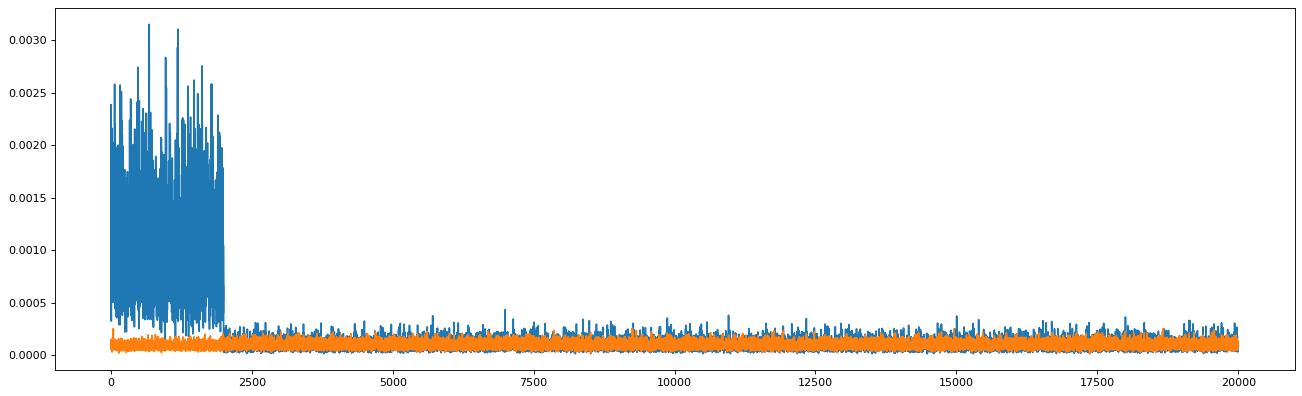

In [472]:
pyplot.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(afsByGene2[:, 0, 1:2].flatten())
pyplot.plot(afsByGene2[:, 0, 0:1].flatten())



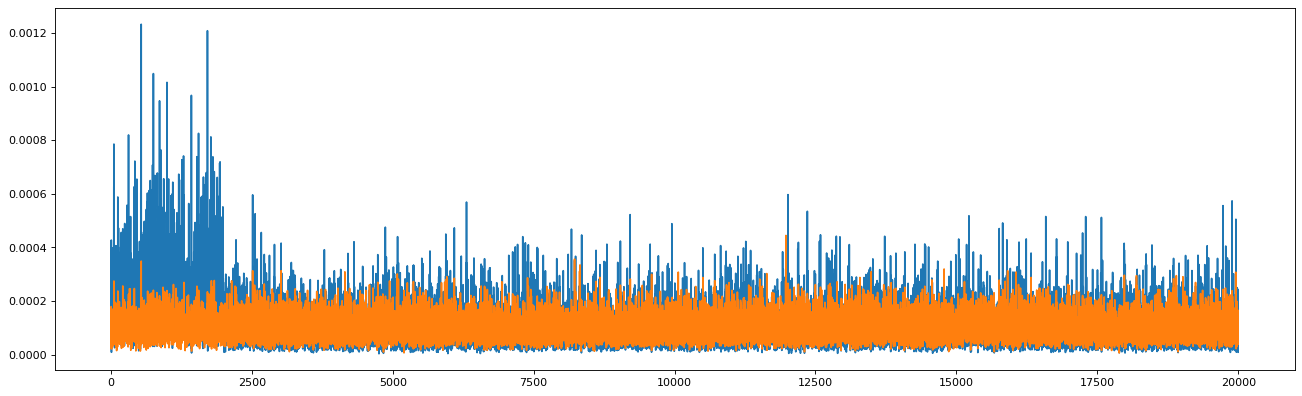

In [79]:
pyplot.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(afsByGeneRR2Shape5[:, 0, 1:2].flatten())
pyplot.plot(afsByGeneRR2Shape5[:, 0, 0:1].flatten())

In [312]:
start = time.time()

l = likelihoodUnivariateFast(altCountsByGene, pDs)

print(l(.001, .01))

time.time() - start

gene sums tensor([10., 10., 16.,  8., 11.,  5., 18.,  4., 19., 12.])
component0 tensor([-2.3691, -0.0995, -0.1592, -2.5701, -0.1094, -0.0497, -1.8668, -0.0398,
        -1.8232, -5.0700])
component1 tensor([-4.6142e-02, -1.0005e-04, -1.6008e-04, -4.8353e-02, -1.1005e-04,
        -5.0025e-05, -4.0344e-02, -4.0021e-05, -3.9813e-02, -9.6359e-02])
tensor(11285.2695)


0.007719278335571289

In [318]:
print(l(0, 0))

component0 tensor([-2.3930, -0.1005, -0.1608, -2.5961, -0.1106, -0.0503, -1.8857, -0.0402,
        -1.8416, -5.1212])
component1 tensor([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0.])
tensor(11215.3643)
